In [1]:
%load_ext autoreload
%autoreload 2

## DARTsort initial detection + DREDge motion estimation demo

This notebook demos a pipeline for getting initial spike detection and registration
running on a Neuropixels dataset (dataset1 from https://figshare.com/articles/dataset/_Imposed_motion_datasets_from_Steinmetz_et_al_Science_2021/14024495?file=26476589)

The recording is loaded and preprocessed using SpikeInterface. If you're working
on a recording which wasn't made with spikeglx like this one, then you can use
SpikeInterface's other read_* functions to load it up.

### Installation + setup

To get everything running, first follow the instructions in the README of this repo
for setting up an environment and installing `dartsort` with `mamba`. Then,
`git clone` the dredge repo: https://github.com/evarol/dredge . Once you clone that
repo, you can install `dredge` with

```
$ git clone https://github.com/evarol/dredge
$ cd dredge
$ cd dredge-python
# (make sure your environment is activated)
$ pip install -e .
```

In [17]:
import numpy as np
import spikeinterface.full as si
from dartsort.main import subtract
from dartsort.util.data_util import DARTsortSorting
import dartsort.vis as dartvis
from pathlib import Path
from dredge.dredge_ap import register
import dredge.motion_util as mu
import matplotlib.pyplot as plt

In [3]:
# path to the place where dataset1 was downloaded
dataset1_path = Path("/mnt/3TB/dataset1/")

# path where you'd like to store output files
output_path = Path("/home/charlie/data/dataset1_demo_output")

# optional cache directory for storing a preprocessed binary
# file. you can choose not to do this
save_preprocessed_data = True
cache_dir = Path("/home/charlie/scratch/dataset1_cache")

In [5]:
output_path.mkdir(exist_ok=True)
assert dataset1_path.exists()

In [6]:
# load up the NP2 dataset from dataset1
rec = si.read_spikeglx(dataset1_path / "p2", stream_id="imec0.ap")

if save_preprocessed_data and cache_dir.exists():
    rec = si.read_binary_folder(cache_dir)
else:
    # preprocessing (mimic IBL's pipeline with spikeinterface)
    rec = si.highpass_filter(rec)
    rec = si.phase_shift(rec)
    bad_channel_ids, channel_labels = si.detect_bad_channels(rec)
    rec = rec.remove_channels(bad_channel_ids)
    rec = si.highpass_spatial_filter(rec)
    rec = si.zscore(rec, num_chunks_per_segment=50, mode="mean+std")

    # you can optionally cache this preprocessed recording, which will
    # speed things up later at the cost of time spent now
    if save_preprocessed_data:
        rec = rec.save(folder=cache_dir, n_jobs=5, chunk_duration="1s")

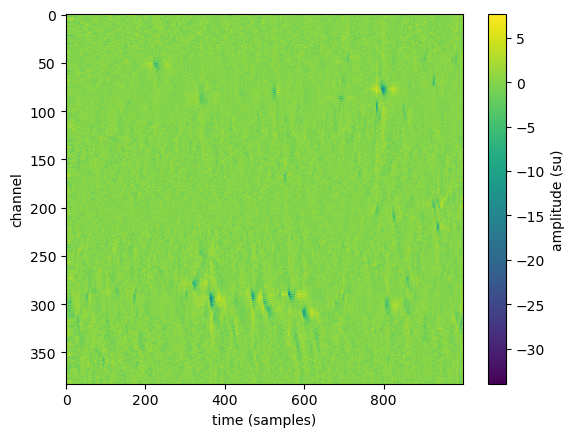

In [8]:
plt.imshow(rec.get_traces(0, 0, 1000).T, aspect="auto")
plt.colorbar(label="amplitude (su)")
plt.xlabel("time (samples)")
plt.ylabel("channel");

In [9]:
# run spike detection and localization
# the default configuration should work in most probes, but there are
# options which can be tweaked in the case that results look strange
# this runs on GPU by default if you have one, and you can set n_jobs
# higher if you have a nice one. this was run on a 1080 with 8GB ram,
# and it used about all of the memory
initial_detections, subtraction_h5 = subtract(rec, output_path, n_jobs=2)

Fit subtraction denoisers 1.0s/it [spk/it=%%%]:   0%|          | 0/40 [00:00<?, ?it/s]

Fit features 1.0s/it [spk/it=%%%]:   0%|          | 0/40 [00:00<?, ?it/s]

Subtraction 1.0s/it [spk/it=%%%]:   0%|          | 0/1957 [00:00<?, ?it/s]

Localization:   0%|          | 0/23 [00:00<?, ?it/s]

In [12]:
# load up extra data including spike locations
initial_detections = DARTsortSorting.from_peeling_hdf5(subtraction_h5, load_simple_features=True)
initial_detections

DARTsortSorting: 2293523 spikes, 1 unit. extra features: denoised_amplitude_vectors, denoised_amplitudes, point_source_localizations, times_seconds.

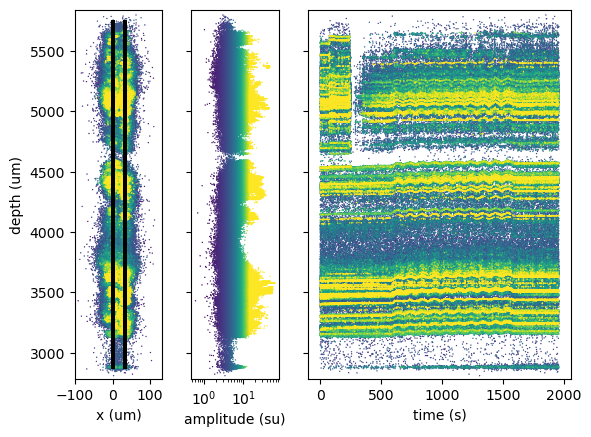

In [14]:
# plot unregistered positions
dartvis.scatter_spike_features(subtraction_h5);

In [15]:
geom = rec.get_channel_locations()

In [18]:
# registration
# localization can put a couple of spikes way off the probe, so we
# first restrict to reasonable spikes
# still working out how to handle this in a cleaner way
z = initial_detections.point_source_localizations[:, 2]
valid = z == np.clip(z, geom[:, 1].min() - 50, geom[:, 1].max() + 50)
z = z[valid]
t = initial_detections.times_seconds[valid]
a = initial_detections.denoised_amplitudes[valid]

# run registration
# there are parameters here to control the placement and number of nonrigid windows, etc
motion_est, extra_info = register(a, z, t)

Cross correlation:   0%|          | 0/7 [00:00<?, ?it/s]

Weights:   0%|          | 0/7 [00:00<?, ?it/s]

Solve:   0%|          | 0/6 [00:00<?, ?it/s]

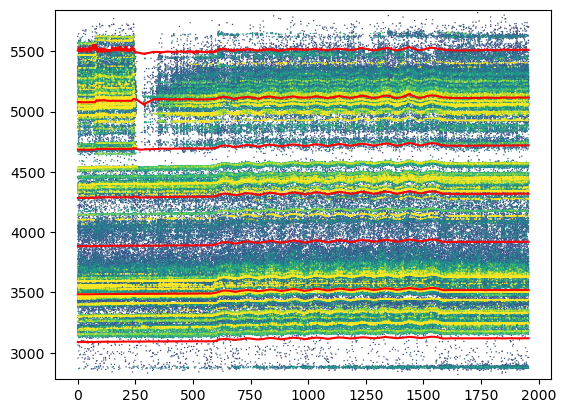

In [20]:
# plot the registration result: motion traces over unregistered spike positions
dartvis.scatter_time_vs_depth(subtraction_h5)
mu.plot_me_traces(motion_est, plt.gca(), color="r");

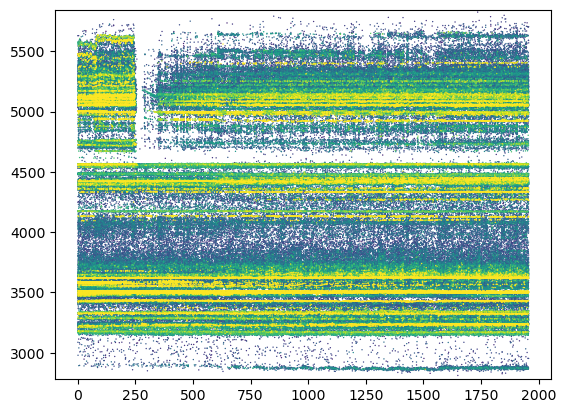

In [23]:
# plot the registered spike positions
dartvis.scatter_time_vs_depth(subtraction_h5, registered=True, motion_est=motion_est);